In [ ]:
import os
import sys
main_path = 'e:\\ehz'
sys.path.append(main_path)
os.chdir(main_path)

import pandas as pd
import numpy as np
import plotly.express as px
import utils

from tqdm import tqdm
import swaplib as swlb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(10, 5)})

import statsmodels.api as sm

In [ ]:
max_length = 10
liquidity_filter = ['0']
brackets = [-np.inf, np.inf]

Z_spread = utils.get_bonds_zspread().dropna(how='all')
Y = utils.get_bond_yields()

Z =Z_spread
#Z = Y*100


In [4]:
roll_dates = utils.roll_dates
roll_in_dates = utils.roll_in_dates
roll_out_dates = utils.roll_out_dates

bonds = utils.get_bonds() # type: ignore
P = utils.get_bond_prices(ptype='mid')
Dirty = utils.get_bond_prices(ptype='dirty')

D = utils.get_bond_duration(ptype = 'mid')
G = utils.get_fld_bonds(fld = 'gamma')
bond_perf = utils.get_bond_perfs()
bond_perf_zsprd = -Z_spread.diff()*(D.shift(1)).loc[Z_spread.index]/100
repo = utils.get_repo('sofr')


ctd_tabs = utils.get_ctd_tabs()
otr_tabs = utils.get_otr_tabs()
compact_ctd_tabs = ctd_tabs.copy()
dates = P.loc[roll_in_dates.loc[ctd_tabs.index[0]]:].index

ctd_tabs = pd.DataFrame(index = dates, columns = compact_ctd_tabs.columns)
ctd_tabs = ctd_tabs.apply(lambda x: compact_ctd_tabs.loc[utils.futs_calendar.loc[x.name]], axis=1)
active_bonds = pd.concat([otr_tabs, ctd_tabs], axis=1)



active_bonds_columns = [c for c in active_bonds.columns if c[-1] in liquidity_filter]
active_bonds_liquid = active_bonds[active_bonds_columns]

adhoc_vol = 1e-4
normalisation_conv = 1e3

basket = bonds.loc[P.columns]
basket_length = len(basket)
basket['length_str'] = basket['length'].astype(str)
basket = basket[basket['length']<max_length]



# %% 
MD = 100*D/Dirty
Convexity_value = 100*G/Dirty
var = (adhoc_vol*MD*1e4)
conv = (0.5*adhoc_vol**2)*Convexity_value*1e4*normalisation_conv
cuspis = [c for c in basket.index if c in Z.columns and c in var.columns and c in conv.columns]

var = var[cuspis].copy()
conv = conv[cuspis].copy()
Z = Z[cuspis].copy()
basket = basket.loc[cuspis]

dates = [d for d in Z_spread.index if d in var.index and d in conv.index]


var = var.loc[dates]
conv = conv.loc[dates]

## compute and save errors

In [5]:
R = pd.DataFrame(index = dates, columns = ['R2'], dtype=float)
E = pd.DataFrame(index = dates, columns = basket.index, dtype=float)
E_test = pd.DataFrame(index = dates, columns = basket.index, dtype=float)


#########################
filter_used = active_bonds_liquid
#########################

x_cols = ['var', 'conv']
y_col = 'z0'
for date in tqdm(dates):
    data = pd.concat((
        var.loc[date],
        conv.loc[date],
        Z.loc[date]
    ), axis=1).dropna()
    data.columns = ['var', 'conv', 'z0']
    active_bonds_date = filter_used.loc[date].dropna().values
    active_bonds_date = [c for c in data.index if c in active_bonds_date]

    X = data[x_cols]
    X = sm.add_constant(X)
    target = data[y_col]
    
    X_train = X.loc[active_bonds_date]
    target_train = target.loc[active_bonds_date]

    model = sm.OLS(target_train, X_train).fit()
    R.loc[date, 'R2'] = model.rsquared
    R.loc[date, model.params.index] = model.params

    E_test.loc[date] = model.predict(X) - target
    E.loc[date] = E_test.loc[date, active_bonds_date]

    R.loc[date, 'E'] = E.loc[date].abs().mean()
    R.loc[date, 'E_max'] = E.loc[date].abs().max()
    R.loc[date, 'E_test'] = E_test.loc[date].abs().mean()
    R.loc[date, 'E_test_max'] = E_test.loc[date].abs().max()



100%|██████████| 4067/4067 [01:46<00:00, 38.36it/s]


In [6]:
display(R.describe().loc[['mean', 'std', 'min', 'max']])
px.line(R)

,R2,const,var,conv,E,E_max,E_test,E_test_max
mean,0.957344,-1.664355,2.830149,2.666069,0.870648,1.806965,4.186074,36.453812
std,0.081334,19.599386,11.972337,23.405541,0.532662,1.110323,3.681740,48.682542
min,0.038369,-68.948770,-129.096643,-55.713259,0.000000,0.000000,0.621096,2.545224
max,1.000000,168.786722,34.934625,324.563757,4.250630,8.402515,48.867200,622.967809


In [8]:
mode = 'strictly_less_than_ten'
E.to_csv(f'data/rv_bonds/{mode}/error_train.csv')
E_test.to_csv(f'data/rv_bonds/{mode}/error_test.csv')

liquid/non liquid

clusters

spreads/flys

# liquid bonds

In [42]:
mode = 'strictly_less_than_ten'
E1 = pd.read_csv(f'data/rv_bonds/{mode}/error_train.csv', index_col=0, parse_dates=True)
E_test1 = pd.read_csv(f'data/rv_bonds/{mode}/error_test.csv', index_col=0, parse_dates=True)

## backtest

In [8]:
tab = D
D_active = filter_used[['CT_2_0', 'CT_3_0', 'CT_5_0', 'CT_7_0']].loc[dates].apply(lambda row:
                                                                       row.apply(lambda cusip : 
                                                                                np.nan if str(cusip)=='nan' else tab.loc[row.name, cusip]) ,
                                                                        axis=1
                                                                       ).dropna()

tab = E
E_active = filter_used[['CT_2_0', 'CT_3_0', 'CT_5_0', 'CT_7_0']].loc[dates].apply(lambda row:
                                                                       row.apply(lambda cusip : 
                                                                                np.nan if str(cusip)=='nan' else tab.loc[row.name, cusip]) ,
                                                                        axis=1
                                                                       ).dropna()

tab = Z
Z_active = filter_used[['CT_2_0', 'CT_3_0', 'CT_5_0', 'CT_7_0']].loc[dates].apply(lambda row:
                                                                       row.apply(lambda cusip : 
                                                                                np.nan if str(cusip)=='nan' else tab.loc[row.name, cusip]) ,
                                                                        axis=1
                                                                       ).dropna()

tab = var
var_active = filter_used[['CT_2_0', 'CT_3_0', 'CT_5_0', 'CT_7_0']].loc[dates].apply(lambda row:
                                                                       row.apply(lambda cusip : 
                                                                                np.nan if str(cusip)=='nan' else tab.loc[row.name, cusip]) ,
                                                                        axis=1
                                                                       ).dropna()

tab = conv
conv_active = filter_used[['CT_2_0', 'CT_3_0', 'CT_5_0', 'CT_7_0']].loc[dates].apply(lambda row:
                                                                       row.apply(lambda cusip : 
                                                                                np.nan if str(cusip)=='nan' else tab.loc[row.name, cusip]) ,
                                                                        axis=1
                                                                       ).dropna()

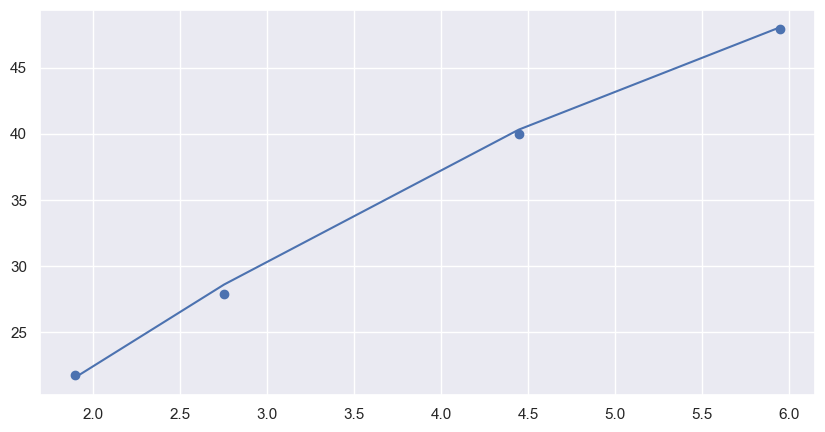

In [10]:
date = E_active.index[-1]
plt.scatter(var_active.loc[date].values, Z_active.loc[date].values)

plt.plot(var_active.loc[date].values, var_active.loc[date].values*R.loc[date, 'var'] + 
                                        conv_active.loc[date].values*R.loc[date, 'conv']+
                                        R.loc[date, 'const'])

In [51]:
(50*1e9*(2*1e-4))/1e6*221

2210.0

In [54]:
20*100/11

181.8181818181818

In [ ]:
200

In [38]:
import pandas as pd
import numpy as np


brackets = [-np.inf, np.inf]
n_clusters = len(brackets) -1
start_date = pd.to_datetime('01/01/2014')


def simpleassignweights(date, row, n_short=1, n_long=1):
    weights = pd.Series(0, index=row.index, dtype= float)
    richest_bonds = row.nlargest(n_short).index
    cheapest_bonds = row.nsmallest(n_long).index
    weights.loc[richest_bonds] = -1/D.loc[date, richest_bonds]
    weights.loc[cheapest_bonds] = 1/D.loc[date, cheapest_bonds]
    return weights

def get_clusters(md):

    md_t = md.copy()
    clusters = []
    for i in range(n_clusters) :
        lower = brackets[i]
        upper = brackets[i+1]
        clusters.append(
            md_t[(md_t > lower) & (md_t <= upper)].index
        )

    return clusters

def clustered_assignweights(date, row, n_short=1, n_long=1):
    md_date = var.loc[date, row.index].copy()  # Macaulay durations
    clusters = get_clusters(md_date)
    # Initialize weights
    weights = pd.Series(0, index=row.index, dtype=float)
    
    # Apply simpleassignweights within each cluster
    for cluster in clusters:
        if len(cluster) > 0:
            sub_signal = row.loc[cluster]
            cluster_weights = simpleassignweights(date, sub_signal, n_short, n_long)/n_clusters
            weights.update(cluster_weights)
    
    return weights


def f(w, date_cluster, date_signal) :
    # gets_expected_pnl on the cluster at date_signal

    md_date = var.loc[date_cluster, w[w!=0].dropna().index].copy()  # Macaulay durations

    clusters = get_clusters(md_date)
    expected = [E_test.loc[date_signal, subset].sort_values().diff().iloc[-1]
                for subset in clusters]
    return clusters, expected


def smooth_weights(W, dates) : 

    W_smooth = W.copy()

    W_uniques = [{} for _ in range(n_clusters)]

    for date_idx, d in tqdm(enumerate(dates[:-1])):
        d1 = d
        d2 = dates[date_idx+1]
        w1 = W_smooth.loc[d1].copy()
        w2 = W_smooth.loc[d2].copy()

        clusters, expected = f(w1, d1, d2) 
        clusters_2, expected_2 = f(w2, d2, d2) 

        for cluster_idx in range(len(clusters)):

            if (expected_2[cluster_idx] - expected[cluster_idx]) < 1: 

                w2.loc[clusters_2[cluster_idx]] = 0
                w2.loc[clusters[cluster_idx]] = w1.loc[clusters[cluster_idx]]

            else : 
                actives = active_bonds.loc[d2]
                actives = actives.mask(actives.duplicated())
                W_uniques[cluster_idx][d2] = actives.apply(lambda x: 0 if x not in clusters_2[cluster_idx] else w2.loc[x])

        W_smooth.loc[d2] = w2

    return W_smooth

In [39]:
W_origin = E.apply(lambda x : clustered_assignweights(x.name, x.dropna(), n_short=1, n_long=1) , axis=1)
dates = E.loc[start_date:].index
W_smooth = smooth_weights(W_origin, dates)

2747it [00:11, 235.21it/s]


In [40]:
bid_offer = 0.2

W = W_smooth
pnl = (100*W.shift(1).loc[dates[1:]]*bond_perf.loc[dates[1:]]).sum(axis=1)
costs =( W.diff().loc[dates[1:]].abs()*D.loc[dates[1:]]*bid_offer).sum(axis=1)
net_pnl = pnl - costs

s_ratio = pnl.mean()/pnl.std()*np.sqrt(255)
s_ratio_net = net_pnl.mean()/net_pnl.std()*np.sqrt(255)
yearly_net_pnl = (net_pnl).groupby(lambda x: x.year).sum().mean()
print(s_ratio, s_ratio_net, yearly_net_pnl)

0.8784601491503262 0.6407260341838943 10.536962089792702


<Axes: >

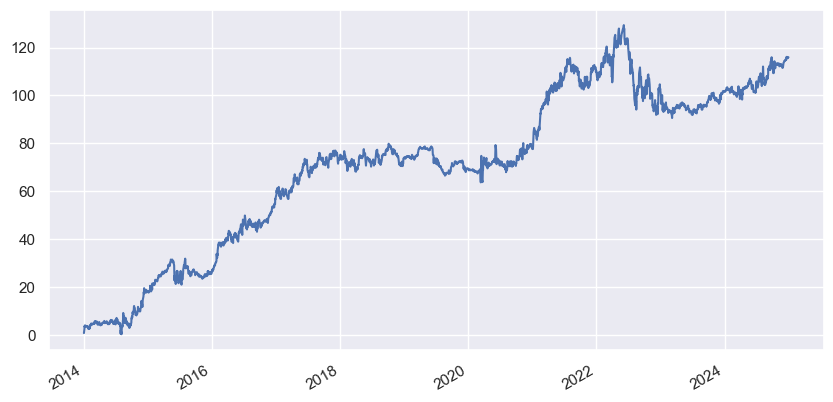

In [41]:
net_pnl.cumsum().plot()

In [ ]:
mode = 'strictly_less_than_ten'
net_pnl.to_csv(f'data/rv_bonds/{mode}/net_pnl.csv')


In [24]:
pnls_per_cluster = n_clusters*[0]
for cluster in range(n_clusters):
    per_trade_df = pd.DataFrame(W_uniques[cluster]).T

    trade_dates = list(per_trade_df.index) + [dates[-1]]
    pnl_per_trade = pd.Series(index = trade_dates[:-1], dtype=float)
    for i, date in tqdm(enumerate(trade_dates[:-1])):
        d1 = utils.add_business_day(date,1)
        d2 = trade_dates[i+1]
        perf_trade = active_bonds.loc[d1].apply(
            lambda cusip: 0 if str(cusip) == 'nan' 
            else bond_perf.loc[d1:d2, cusip].sum())
        
        
        pnl_per_trade.loc[date] = 100*(perf_trade*per_trade_df.loc[date]).sum()
    pnls_per_cluster[cluster] = pnl_per_trade

125it [00:00, 289.51it/s]
212it [00:00, 339.74it/s]


In [25]:
[pnl_per_trade.loc[:].sum() for pnl_per_trade in pnls_per_cluster]

[np.float64(68.20575579990293), np.float64(93.79301552414817)]

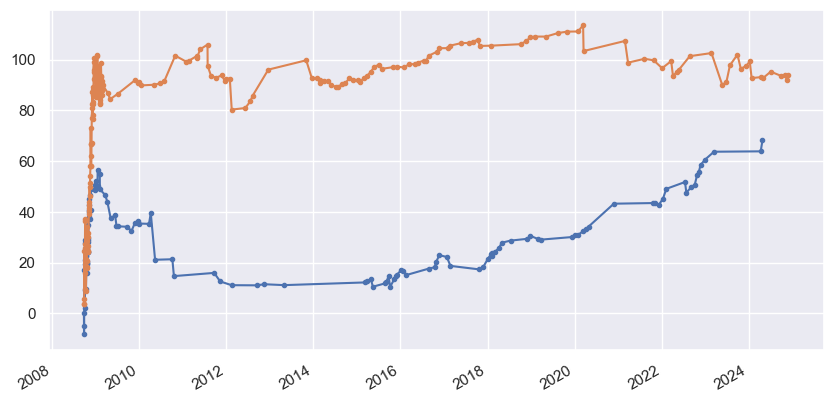

In [26]:
for pnl_per_trade in pnls_per_cluster:
    pnl_per_trade.loc[start_date:].cumsum().plot(marker='.')

In [16]:
pnl1 = pnls_per_cluster[0]

In [19]:
pnl2 = pnls_per_cluster[1]

<Axes: >

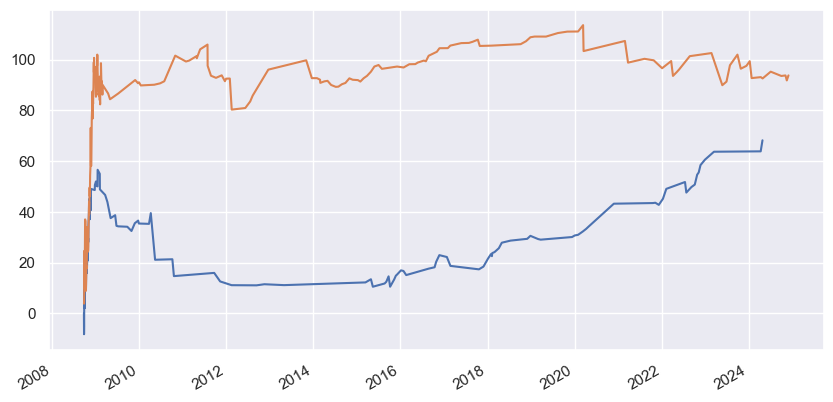

In [20]:
pnl1.cumsum().plot()
pnl2.cumsum().plot()

In [48]:
per_trade_df = pd.DataFrame(W_uniques[0]).T

In [55]:
per_trade_df = per_trade_df[per_trade_df.columns[(per_trade_df!=0).any()]]

<Axes: >

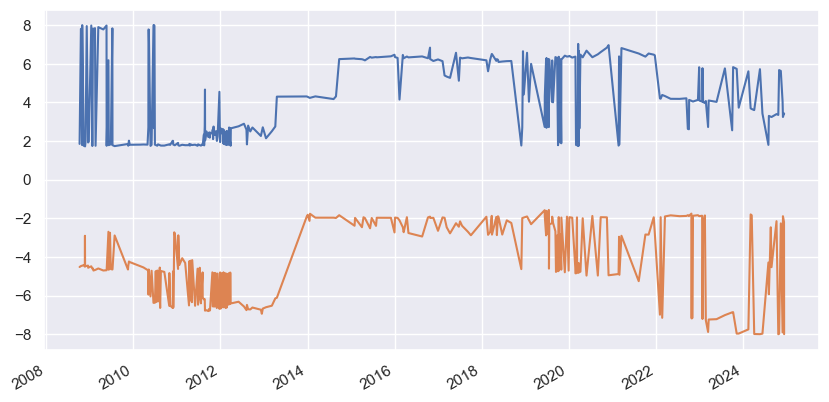

In [64]:
per_trade_df.apply(lambda x: var.loc[x.name, active_bonds.loc[x.name,x.idxmax()]], axis=1).plot()
per_trade_df.apply(lambda x: -var.loc[x.name, active_bonds.loc[x.name,x.idxmin()]], axis=1).plot()

In [65]:
rates = utils.get_swap_rates()

<Axes: xlabel='Date'>

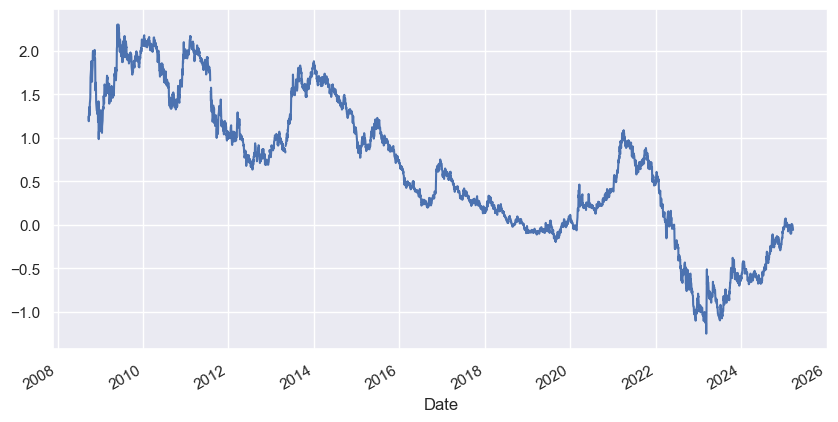

In [69]:
(rates['7Y'] - rates['2Y']).plot()